In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tubi_data_runtime as tdr
from sklearn.metrics import precision_score
from scipy.stats import randint as sp_randint
from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve #make learning curve to justify more data collection

from sklearn.model_selection import StratifiedKFold
num_splits = 5.0
kf = StratifiedKFold(n_splits=int(num_splits), random_state=0, shuffle=True)

In [2]:
'''
Link to CTAS query: 
https://github.com/TJ-Tubi/IP_Soft_Match/blob/master/create_ipsm_res_base.sql
'''
QUERY_AGG = """
select * from scratch.ipsm_911_res
"""

df = \
    tdr.query_redshift(QUERY_AGG)\
    .to_df()

#drop dismissals; using them as labels significantly increased variance
df = df[np.isfinite(df['button_id'])]
df['label'] = 1-df['label'] #flip the labels so precision/recall makes more sense

In [3]:
df.shape

(74645, 18)

In [4]:
# df_duplicate_labels=df.groupby(['mobile_device_id', 'ott_device_id'])['label'].nunique().reset_index().query('label>1')

In [5]:
QUERY_IP_NUM_DEVICES = """
with mobile_ip_tally as (
  select distinct mobile_device_id, case when client_ip ilike '%.%' then client_ip
              when client_ipv6 is not NULL and len(client_ipv6)>20 then client_ipv6
--               when client_ip ilike '%:%' and client_ipv6 is not NULL and len(client_ipv6)>20 then client_ipv6
              else NULL
         end as client_ip
  from scratch.ipsm_911_res i join server_impressions s
  on i.mobile_device_id=s.device_id
  --where ts>dateadd('year', -1, '2019-10-01')
)
, ott_ip_tally as (
  select distinct ott_device_id, case when client_ip ilike '%.%' then client_ip
              when client_ipv6 is not NULL and len(client_ipv6)>20 then client_ipv6
--               when client_ip ilike '%:%' and client_ipv6 is not NULL and len(client_ipv6)>20 then client_ipv6
              else NULL
         end as client_ip
  from scratch.ipsm_911_res i join server_impressions s
  on i.ott_device_id=s.device_id
  --where ts>dateadd('year', -1, '2019-10-01')
)
select m.mobile_device_id, o.ott_device_id, 
count(distinct case when m.client_ip=o.client_ip then m.client_ip else NULL end)
  as num_same_ips,
(count(distinct m.client_ip)+count(distinct o.client_ip))-num_same_ips as num_total_ips,
case when num_total_ips>0 then num_same_ips::float/num_total_ips else 0 end as same_ips_ratio
from scratch.ipsm_911_res i
join mobile_ip_tally m on i.mobile_device_id=m.mobile_device_id
join ott_ip_tally o on i.ott_device_id=o.ott_device_id
group by 1,2
"""
df_ip_num_devices = \
    tdr.query_redshift(QUERY_IP_NUM_DEVICES)\
    .to_df()

In [6]:
df = df.merge(df_ip_num_devices, on=['mobile_device_id', 'ott_device_id'], suffixes=(False, False))

In [7]:
QUERY_GEO_NUM_DEVICES = """
with mobile_ip_tally as (
  select distinct mobile_device_id, geo_zip
  from scratch.ipsm_911_res i join server_impressions s
  on i.mobile_device_id=s.device_id
  where ts>dateadd('year', -1, '2019-10-01')
)
, ott_ip_tally as (
  select distinct ott_device_id, geo_zip
  from scratch.ipsm_911_res i join server_impressions s
  on i.ott_device_id=s.device_id
  where ts>dateadd('year', -1, '2019-10-01')
)
select m.mobile_device_id, o.ott_device_id, 
count(distinct case when m.geo_zip=o.geo_zip then m.geo_zip else NULL end)
  as num_same_zips,
(count(distinct m.geo_zip)+count(distinct o.geo_zip))-num_same_zips as num_total_zips,
case when num_total_zips>0 then num_same_zips::float/num_total_zips else 0 end as same_zips_ratio
from scratch.ipsm_911_res i
join mobile_ip_tally m on i.mobile_device_id=m.mobile_device_id
join ott_ip_tally o on i.ott_device_id=o.ott_device_id
group by 1,2
"""
df_zip_num_devices = \
    tdr.query_redshift(QUERY_GEO_NUM_DEVICES)\
    .to_df()

In [8]:
df = df.merge(df_zip_num_devices, on=['mobile_device_id', 'ott_device_id'], suffixes=(False, False))

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df.shape

(74588, 24)

## Preprocess (scale and transform)

In [12]:
df['num_same_series_log'] = np.log(df['num_same_series']+1)
df['num_same_movies_log'] = np.log(df['num_same_movies']+1)
df['overlap_seconds_log'] = np.log(df['overlap_seconds']+1)
df['same_movies_ratio_log'] = np.log(df['same_movies_ratio']+1)
df['same_series_ratio_log'] = np.log(df['same_series_ratio']+1)
df['timegap_log'] = np.log(abs(df['timegap'])+1)
df['same_ips_ratio_log'] = np.log(abs(df['same_ips_ratio'])+1)
df['num_same_ips_log'] = np.log(abs(df['num_same_ips'])+1)
# df['num_mobile_log'] = np.log(abs(df['num_mobile'])+1)
df['num_ott_log'] = np.log(abs(df['num_ott'])+1)

features = ['mobile_registered', 'num_same_series_log', 'num_same_movies_log', 
            'overlap_seconds_log',
            'same_movies_ratio_log', 'same_series_ratio_log', 
            'timegap_log',
            'same_ips_ratio_log', 'num_same_ips_log', 
            'total_nap_tvt', 'total_ap_tvt',
            'overlap_ratio',
            'num_total_zips', 'same_zips_ratio', 'num_ott_log']

X=scale(df[features].values)
y=df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Explore and Visualize

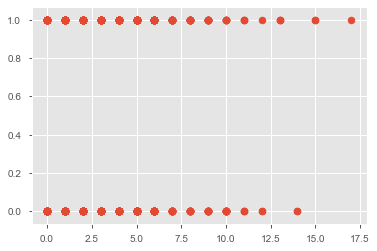

In [7]:
plt.scatter(df['num_same_series'], df['label'])

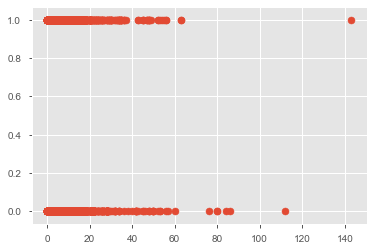

In [8]:
plt.scatter(df['num_same_movies'], df['label'])

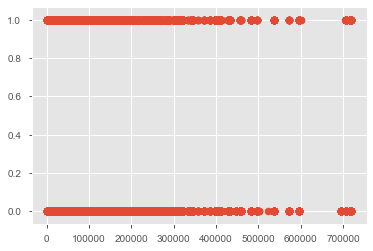

In [9]:
_ = plt.scatter(df['overlap_seconds'], df['label'])

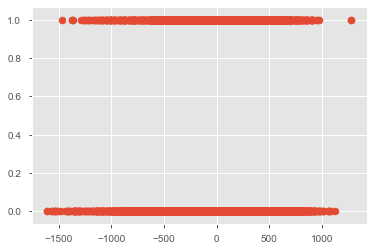

In [10]:
_ = plt.scatter(df['timegap'], df['label'])

## Key Insight
Ratios and temporal component

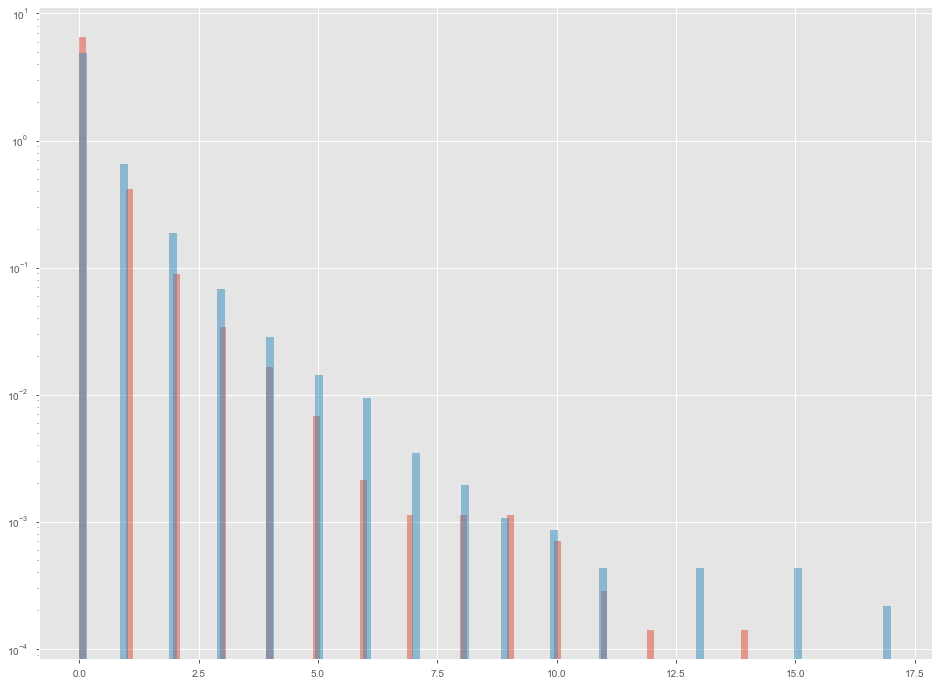

In [60]:
plt.figure(figsize=(16,12))
_ = plt.hist(df[df['label']==0]['num_same_series'], alpha=0.5, density=True, bins=100, log=True)
_ = plt.hist(df[df['label']==1]['num_same_series'], alpha=0.5, density=True, bins=100, log=True)

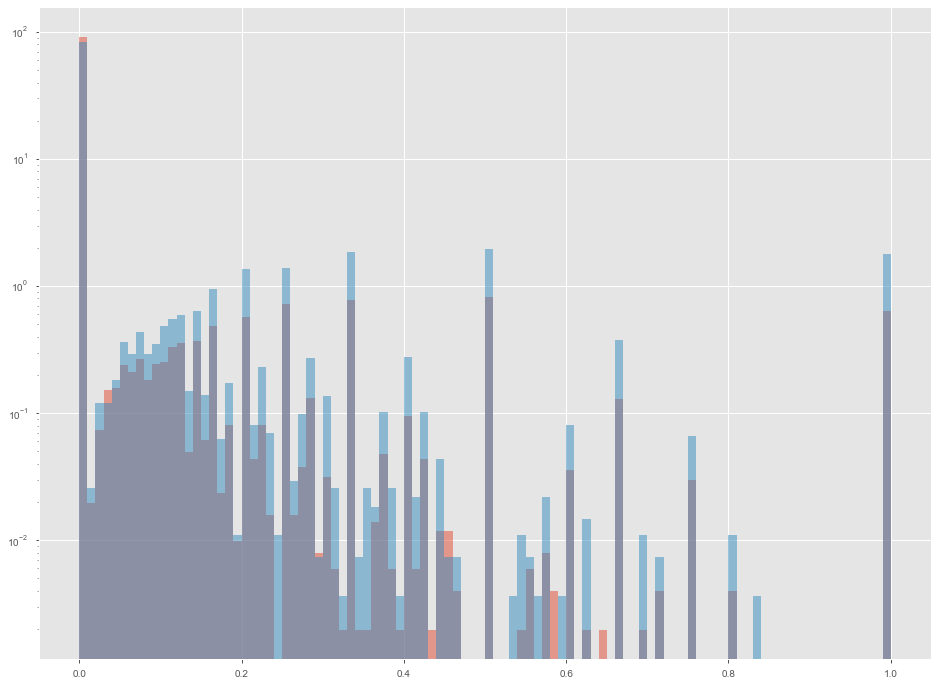

In [61]:
plt.figure(figsize=(16,12))
_ = plt.hist(df[df['label']==0]['same_series_ratio'], alpha=0.5, density=True, bins=100, log=True)
_ = plt.hist(df[df['label']==1]['same_series_ratio'], alpha=0.5, density=True, bins=100, log=True)

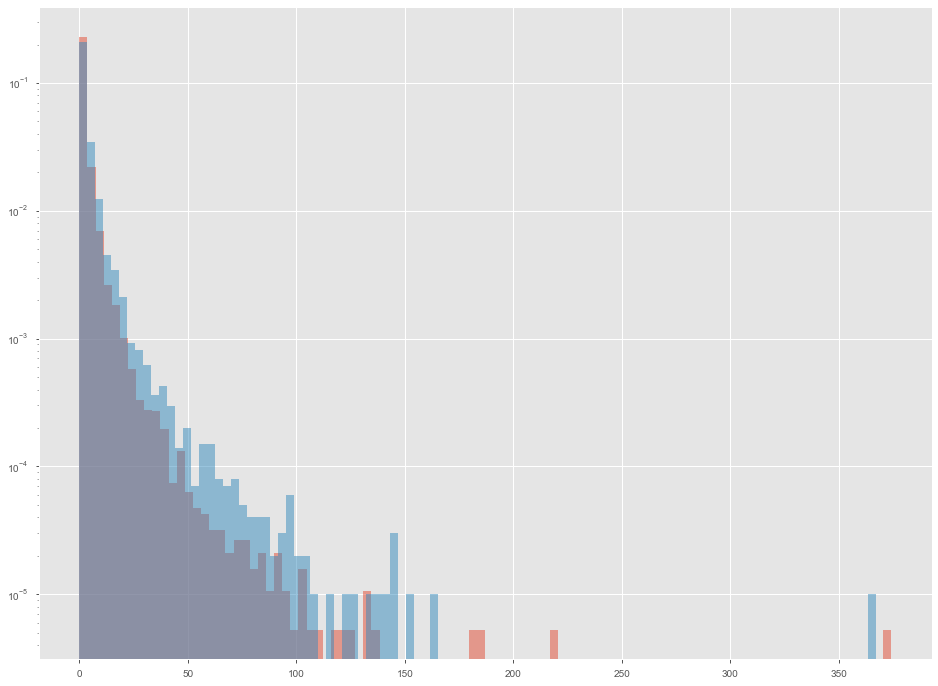

In [62]:
plt.figure(figsize=(16,12))
_ = plt.hist(df[df['label']==0]['num_same_movies'], alpha=0.5, density=True, bins=100, log=True)
_ = plt.hist(df[df['label']==1]['num_same_movies'], alpha=0.5, density=True, bins=100, log=True)

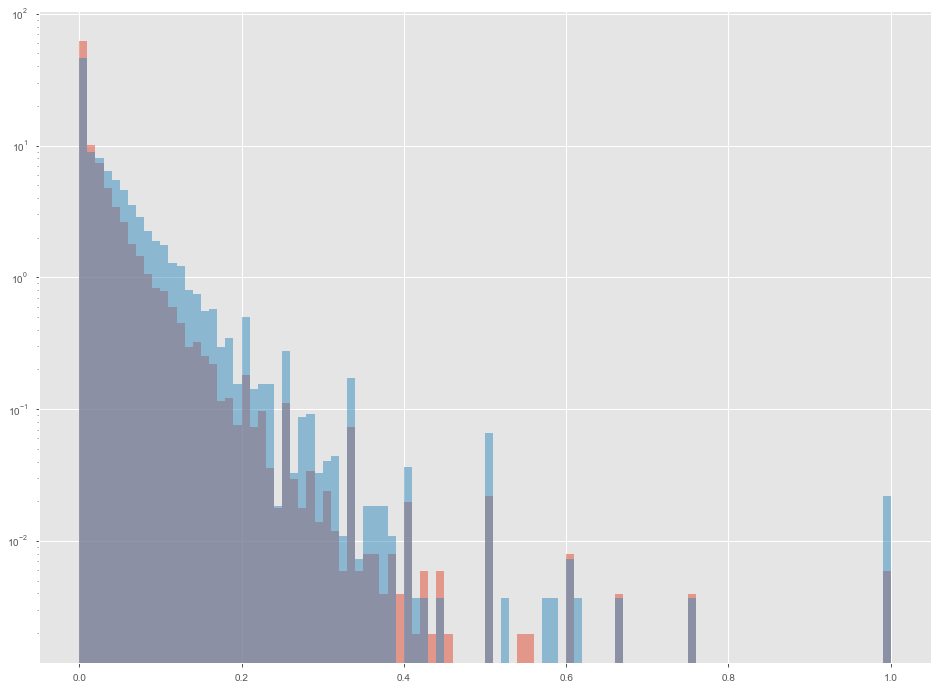

In [63]:
plt.figure(figsize=(16,12))
_ = plt.hist(df[df['label']==0]['same_movies_ratio'], alpha=0.5, density=True, bins=100, log=True)
_ = plt.hist(df[df['label']==1]['same_movies_ratio'], alpha=0.5, density=True, bins=100, log=True)

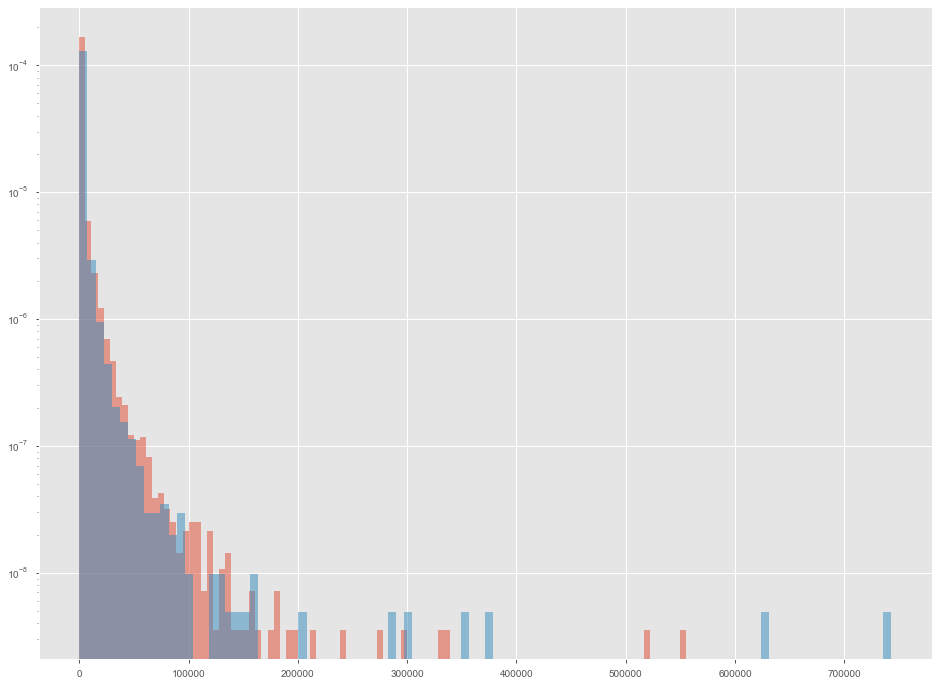

In [64]:
plt.figure(figsize=(16,12))
_ = plt.hist(df[df['label']==0]['overlap_seconds'], alpha=0.5, density=True, bins=100, log=True)
_ = plt.hist(df[df['label']==1]['overlap_seconds'], alpha=0.5, density=True, bins=100, log=True)

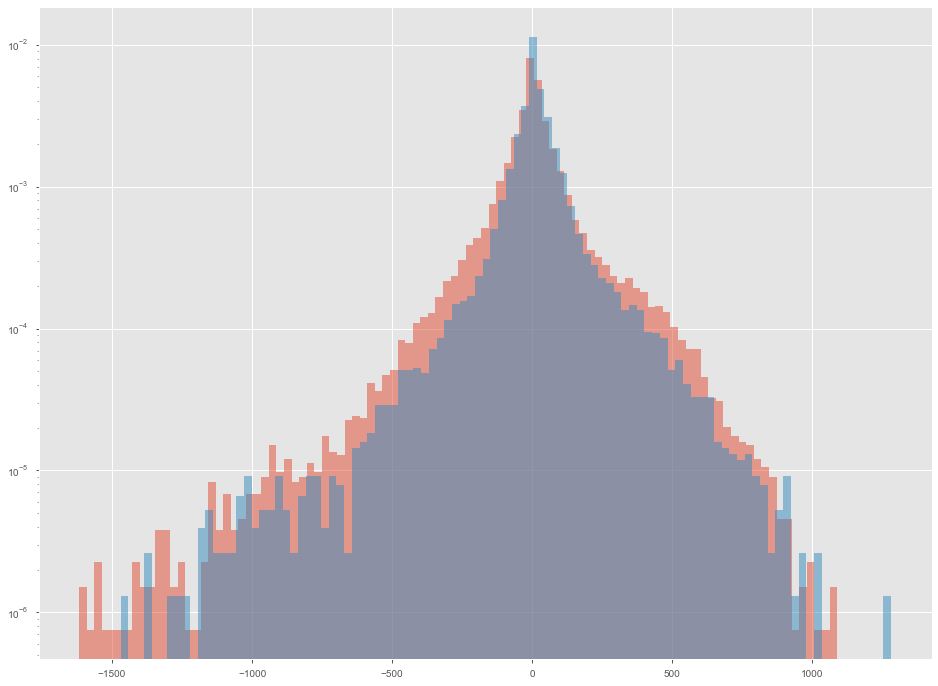

In [107]:
plt.figure(figsize=(16,12))
_ = plt.hist(df[df['label']==0]['timegap'], alpha=0.5, density=True, bins=100, log=True)
_ = plt.hist(df[df['label']==1]['timegap'], alpha=0.5, density=True, bins=100, log=True)

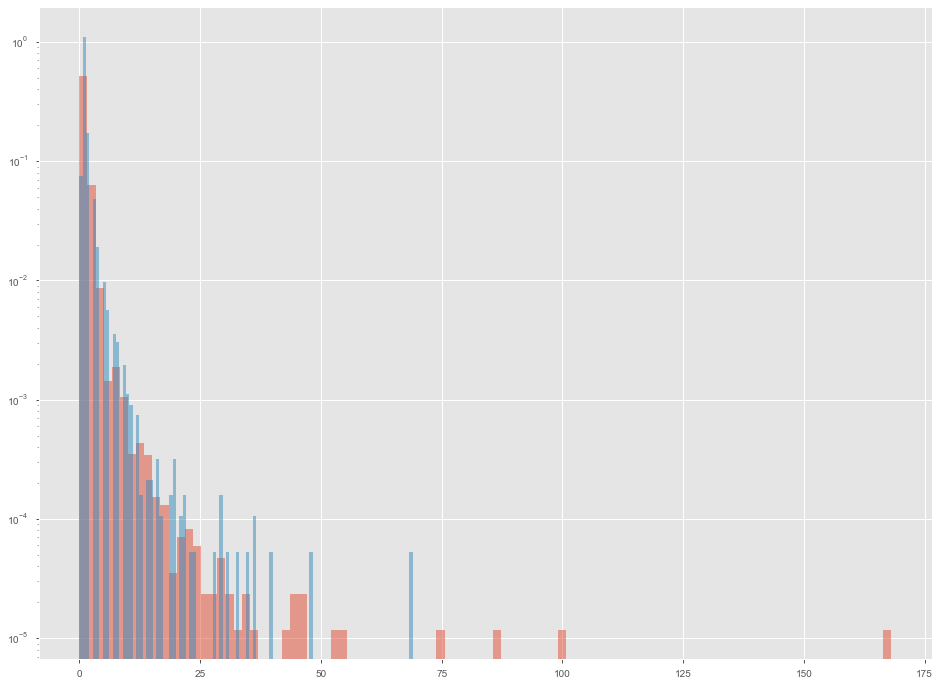

In [67]:
plt.figure(figsize=(16,12))
_ = plt.hist(df[df['label']==0]['num_same_ips'], alpha=0.5, density=True, bins=100, log=True)
_ = plt.hist(df[df['label']==1]['num_same_ips'], alpha=0.5, density=True, bins=100, log=True)

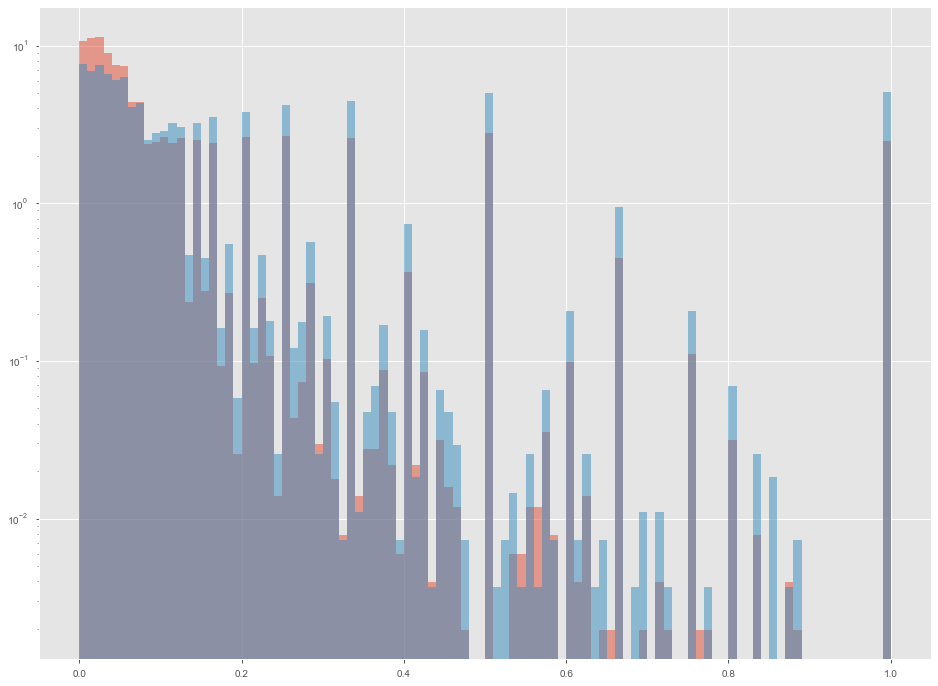

In [68]:
plt.figure(figsize=(16,12))
_ = plt.hist(df[df['label']==0]['same_ips_ratio'], alpha=0.5, density=True, bins=100, log=True)
_ = plt.hist(df[df['label']==1]['same_ips_ratio'], alpha=0.5, density=True, bins=100, log=True)

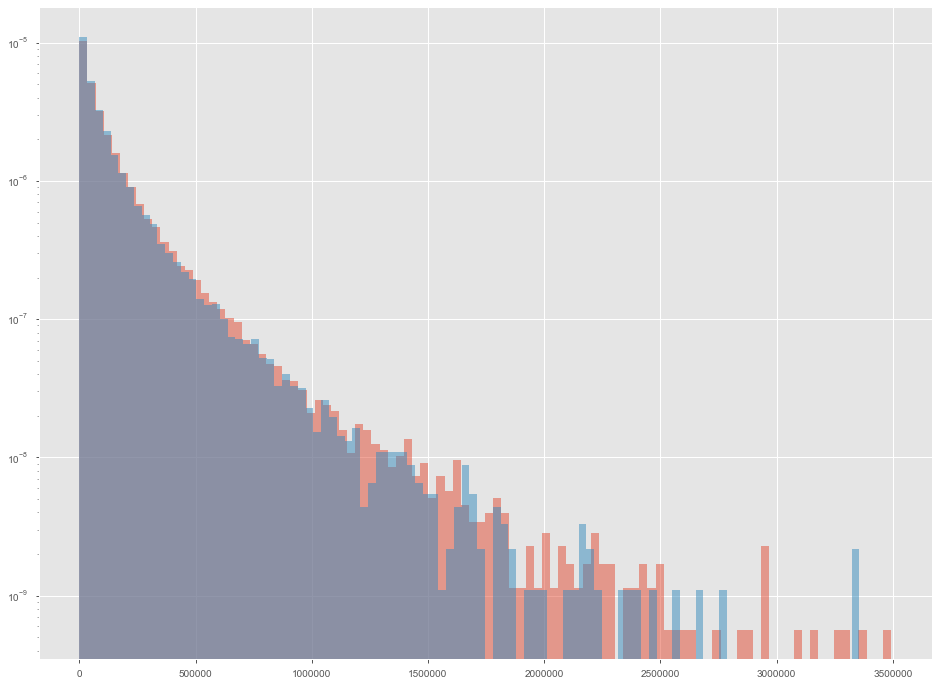

In [69]:
plt.figure(figsize=(16,12))
_ = plt.hist(df[df['label']==0]['total_nap_tvt'], alpha=0.5, density=True, bins=100, log=True)
_ = plt.hist(df[df['label']==1]['total_nap_tvt'], alpha=0.5, density=True, bins=100, log=True)

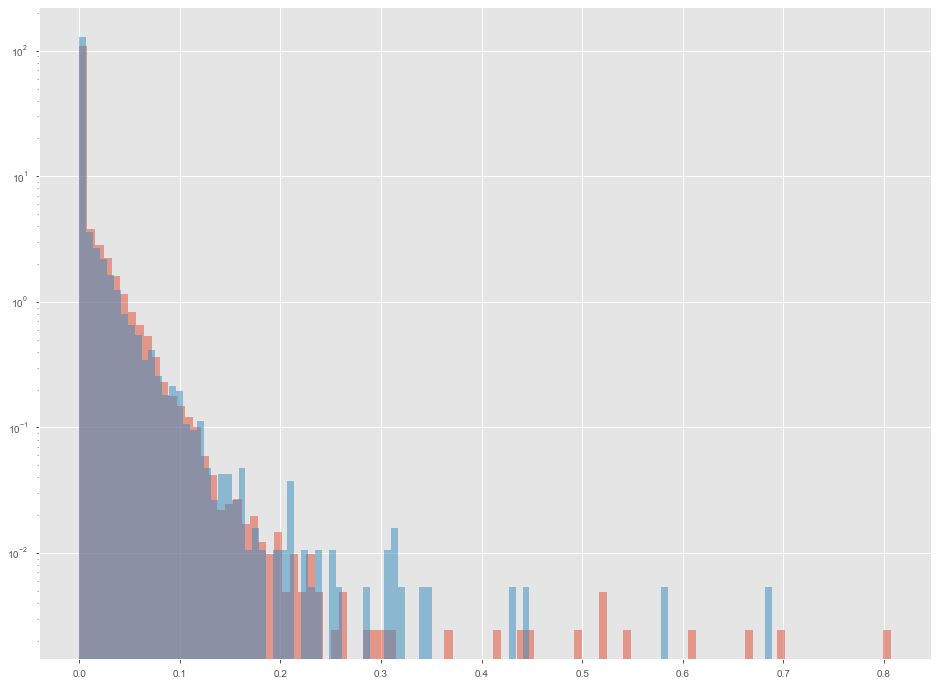

In [70]:
plt.figure(figsize=(16,12))
_ = plt.hist(df[df['label']==0]['overlap_ratio'], alpha=0.5, density=True, bins=100, log=True)
_ = plt.hist(df[df['label']==1]['overlap_ratio'], alpha=0.5, density=True, bins=100, log=True)

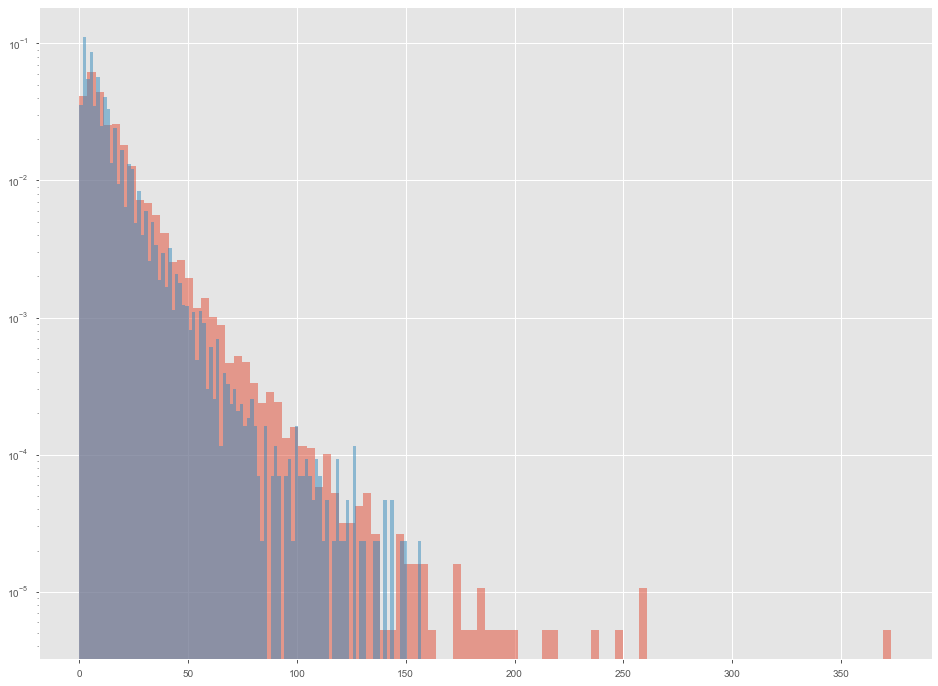

In [71]:
plt.figure(figsize=(16,12))
_ = plt.hist(df[df['label']==0]['num_total_zips'], alpha=0.5, density=True, bins=100, log=True)
_ = plt.hist(df[df['label']==1]['num_total_zips'], alpha=0.5, density=True, bins=100, log=True)

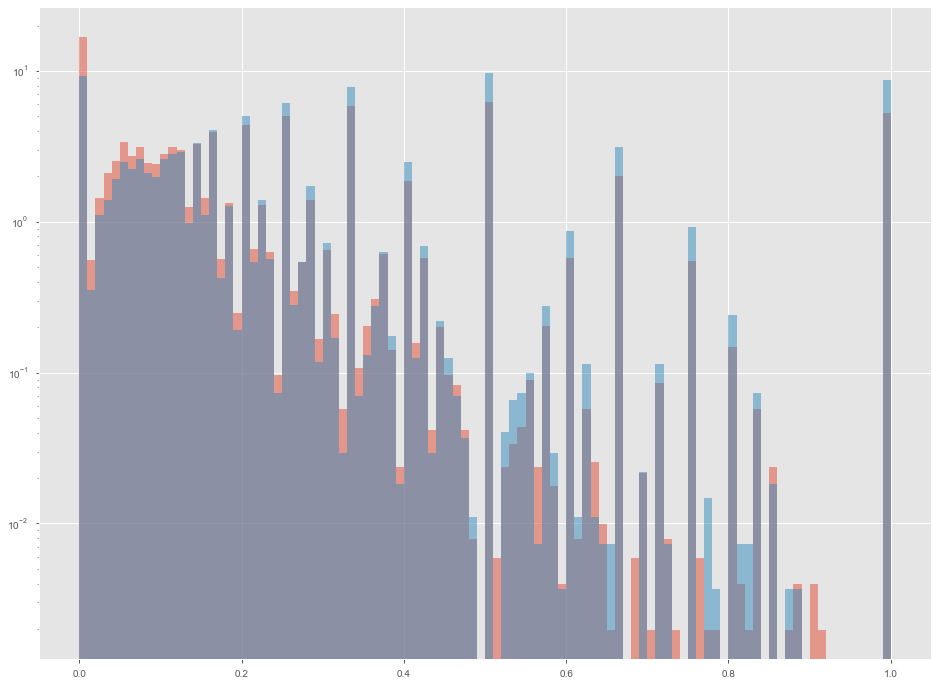

In [72]:
plt.figure(figsize=(16,12))
_ = plt.hist(df[df['label']==0]['same_zips_ratio'], alpha=0.5, density=True, bins=100, log=True)
_ = plt.hist(df[df['label']==1]['same_zips_ratio'], alpha=0.5, density=True, bins=100, log=True)

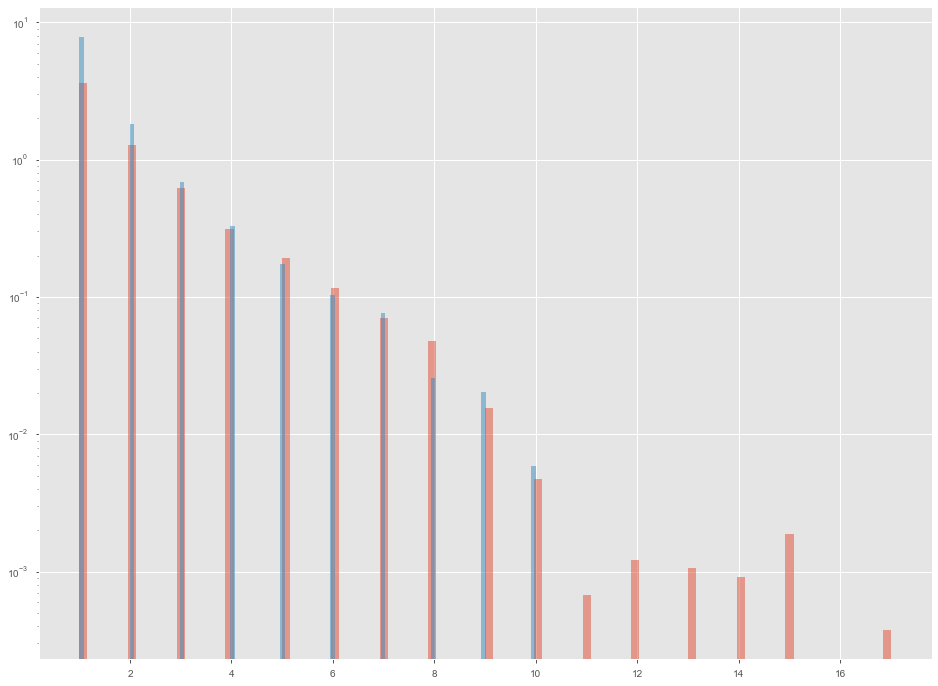

In [121]:
plt.figure(figsize=(16,12))
_ = plt.hist(df[df['label']==0]['num_mobile'], alpha=0.5, density=True, bins=100, log=True)
_ = plt.hist(df[df['label']==1]['num_mobile'], alpha=0.5, density=True, bins=100, log=True)

## Scoring
The labels are not so skewed that accuracy is meaningless. 
However, the key usecases for this data (inform mobile->OTT migration, adjust KPIs, cold-starting recommendations etc), minimizing false positives (assigning a match when in reality a mismatch) is more important than finding all matches at the expense of false positives. Therefore, precision is used as a secondary metric. 

Reminder again that the organic labels has 0 as a match, 1 as mismatch. These are flipped here to resolve confusion in interpreting precision/recall

The highest accuracy observed was 88.8% via random-search optimized random forest

The highest precision observed was 90.8% via the same strategy

In [13]:
1-sum(y)/len(y)

0.6313750201104735

In [32]:
clf = RandomForestClassifier(n_estimators=150, max_depth=390, min_samples_split=6, 
                             min_samples_leaf=2, 
                             max_features=1,
                             bootstrap=True,
                             criterion='gini',
                             random_state=0, 
                             n_jobs=-1)
clf.fit(X_train, y_train)
clf.score(X_test, y_test) # accuracy

0.6834026008848371

In [33]:
y_pred = clf.predict(X_test)
precision_score(y_test, y_pred) # precision

0.6406649616368286

In [133]:
importances = clf.feature_importances_

Feature ranking:
1. feature 9 (0.145813)
2. feature 7 (0.129878)
3. feature 6 (0.126487)
4. feature 10 (0.116489)
5. feature 13 (0.084320)
6. feature 12 (0.083490)
7. feature 4 (0.083467)
8. feature 15 (0.036593)
9. feature 5 (0.034086)
10. feature 2 (0.032385)
11. feature 14 (0.029932)
12. feature 11 (0.023211)
13. feature 3 (0.022770)
14. feature 8 (0.021310)
15. feature 0 (0.015746)
16. feature 1 (0.014022)


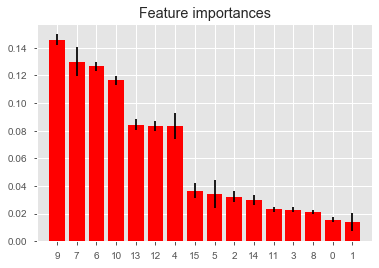

In [134]:
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [136]:
_ = [print(i,v) for i,v in enumerate(features)]

0 mobile_registered
1 num_same_series_log
2 num_same_movies_log
3 overlap_seconds_log
4 same_movies_ratio_log
5 same_series_ratio_log
6 timegap_log
7 same_ips_ratio_log
8 num_same_ips_log
9 total_nap_tvt
10 total_ap_tvt
11 overlap_ratio
12 num_total_zips
13 same_zips_ratio
14 num_mobile_log
15 num_ott_log


In [145]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
param_dist = {
#     "n_estimators":np.logspace(0.6, 2.5, 25, dtype=int),
              "n_estimators":sp_randint(35, 300),
#               "max_depth": np.logspace(0.6, 3.0, 25, dtype=int),
              "max_depth": sp_randint(20, 1000),
              "max_features": sp_randint(1, X_train.shape[1]),
              "min_samples_split": sp_randint(2, 11),
#               "bootstrap": [True, False],
#               "criterion": ["gini", "entropy"]
             }

In [146]:
n_iter_search = 100
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   scoring='precision',
                                   n_iter=n_iter_search, cv=kf, iid=False, n_jobs=-1)
random_search.fit(X_train, y_train)
report(random_search.cv_results_)

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Model with rank: 1
Mean validation score: 0.622 (std: 0.009)
Parameters: {'max_depth': 390, 'max_features': 1, 'min_samples_split': 4, 'n_estimators': 166}

Model with rank: 2
Mean validation score: 0.619 (std: 0.008)
Parameters: {'max_depth': 598, 'max_features': 1, 'min_samples_split': 7, 'n_estimators': 261}

Model with rank: 3
Mean validation score: 0.618 (std: 0.011)
Parameters: {'max_depth': 428, 'max_features': 1, 'min_samples_split': 9, 'n_estimators': 144}



In [147]:
random_search.score(X_test, y_test)

0.6414189837008629

In [148]:
random_search.predict_proba(X_test)

array([[0.71928057, 0.28071943],
       [0.79491818, 0.20508182],
       [0.73751493, 0.26248507],
       ...,
       [0.81302384, 0.18697616],
       [0.78169769, 0.21830231],
       [0.43012581, 0.56987419]])

In [466]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=20, max_depth=50, objective='binary:logistic')
xgb.fit(X_train, y_train)
xgb.score(X_test, y_test)

0.8346239377333016

In [472]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        "n_estimators":np.logspace(0.6, 2.0, 15, dtype=int),
         "max_depth": np.logspace(0.6, 2.5, 15, dtype=int),
        }
xgb = XGBClassifier(learning_rate=0.02, objective='binary:logistic')

In [473]:
random_search_xgb = RandomizedSearchCV(xgb, param_distributions=params, n_iter=20, n_jobs=-1,
                                   cv=kf, random_state=0)
random_search_xgb.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.02, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None...
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'max_depth': array([  3,   5,   7,  10,  13,  18,  25,  35,  48,  66,  90, 123, 169,
       231, 316]),

In [474]:
report(random_search_xgb.cv_results_)

Model with rank: 1
Mean validation score: 0.835 (std: 0.000)
Parameters: {'subsample': 0.8, 'n_estimators': 79, 'min_child_weight': 1, 'max_depth': 66, 'gamma': 1.5, 'colsample_bytree': 0.8}

Model with rank: 2
Mean validation score: 0.832 (std: 0.001)
Parameters: {'subsample': 0.8, 'n_estimators': 63, 'min_child_weight': 1, 'max_depth': 169, 'gamma': 1.5, 'colsample_bytree': 0.8}

Model with rank: 3
Mean validation score: 0.823 (std: 0.001)
Parameters: {'subsample': 0.8, 'n_estimators': 31, 'min_child_weight': 1, 'max_depth': 35, 'gamma': 1, 'colsample_bytree': 0.8}



In [570]:
random_search_xgb.score(X_test, y_test)

# Conclusions 

Precision was used as the scoring method as the applications for device matches are likely more sensitive to false positives (mismatch) than to false negatives (ignoring a match). A recall of 90% means than if the model idenfies a device pair as the same user, there is a 90% chance that it is a true positive. Optimizing for this score however means that we may increase the false negatives, and other metrics are available that balances this trade-off. 

Major caveats: 
- It is not known how well this model generalizes to all tubi devices. The in-app message ground truth labels comes from devices that are reacheable via braze, which is likely not IID with all Tubi users. 
- It is also not known how trust-worthy the in-app message labels are; if there is noise for those who respond, is the noise randomized or biased? 
- Currently I am excluding the 'dismissal' labels, users who closed the in-app message without clicking on yes or no. Using this label as yes or no directly added a lot of noise. It may be better to use them as a third class.  

The basis of this analysis is still user activity on Tubi, thus only returning mobile/ott devices were included in the IAM to generate labels. There are no features identified that enables immediate identification of new users without at least some viewing activity. 

In fact, the key insight is using user behavior over time (e.g. overlapping viewtime, ratio of shared IPs over all IPs visited etc) to inform whether or not two devices belong to the same user. This current work trains a classification model, and reduces the temporal component to metrics aggregated down to device pair. Using a temporal input to continually probability using a Bayesian model may yield even better results. Still, it isn't possible at present to make high precision decisions without priors. 

# Next Steps
- Explore bayesian probabilistic modeling using time series input
- Think of ways to utilize the 'dismissal' data (3rd class? Unsupervised learning? how to valdiate if these users will dismiss in-app messages?)
- Confirm model identified matches with additional in-app message 
- Estimate mobile->OTT migration by applying model to all devices in our data